## Description

- for the final results, it would be like something  like the image I attached
(from https://academic.oup.com/joc/article-abstract/63/6/1011/4085988?redirectedFrom=fulltext)

- What I would like to illustrate is what is the meaning of the terms like COVID-19 and how the meaning(s) of COVID-19 change as time progresses from Dec. 2019 to April 2020. Would we, for example, identify possible concept clusters that represent unique dimension of meaning of the complex concept. So I assume in terms of the image I posted earlier to you, the answer is the first one, "a unique word pair...that...occurs within some immediate context" For instance, the first line is the word pair of "Dengue fever" and "pandemic" and the second is "cause" and "emergence"

- Another reason that I used Wordij is about the "drop words" like prepositions and Wordij already has a txt document which can be revised in terms of our own need to remove prepositions etc. from the corpus. I assume some one should also have that in the case of py.


### Work flow

1. Import texts
2. Split into sentences
3. N-gram tokenization
4. Preprocessing: No stop words, only certain word types
5. Edge-list conversion
6. Network

## 1. Importing texts

Using the novel "The Strange Case Of Dr. Jekyll And Mr. Hyde" by Robert Louis Stevenson as example (from the Project Gutenberg: https://gutenberg.org).

URL to plain text: https://gutenberg.org/files/43/43-0.txt

The text is imported with the front matter and end matter removed.

In [1]:
import requests
import re

response = requests.get("https://gutenberg.org/files/43/43-0.txt")

text_raw = response.text

text_regex = re.compile(r"(?<=\*\*\* START OF THIS PROJECT GUTENBERG EBOOK).*(?=\*\*\* END OF THIS PROJECT GUTENBERG EBOOK)", re.DOTALL)
text = re.findall(text_regex, text_raw)[0]

## 2. Split into sentences

In order to ensure that words occuring in different sentences (on each side of a period), the text is split into sentences by ".".

To avoid splitting at "dr." and "mr.", every "." found in "dr." or "mr." (regardless of case) is removed.

In [2]:
dr_mr = re.compile(r"(?<=\bdr|mr)\.", re.IGNORECASE)

text = re.sub(dr_mr, "", text)
text_sentences = text.split(".")

## 3. N-gram tokenization

With the text as sentences, the sentences can now be converted to ngrams.

The ngram is here used to define the immediate context. The range is set to five (`ngram_range = (5,5)`), meaning words are paired together in pairs of five words next to each other.

The output of the code below is a list of 5 word ngrams.

By doing this, the assumption is that words occuring within five words of each other are in context of another.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
import itertools

vectorizer = CountVectorizer(lowercase = False, ngram_range=(5,5)) # Defining vectorizer
analyzer = vectorizer.build_analyzer() # Creating analyzer using vectorizer

text_ngrams = [analyzer(sentence) for sentence in text_sentences] # Each sentence is processed using the vectorizer

text_ngrams_flat = list(itertools.chain(*text_ngrams)) # Flattening list (instead of being nested as a list of lists)

## 4. Preprocessing

The ngrams are preprocessed with the following steps:

- Removing stopwords (A standard list of stop words from `spacy` is used)

- Removing punctuation (as defined in `string.punctuation`)

- Keeping only certain word types: proper nouns (`PROPN`), adjectives (`ADJ`) and nouns (`NOUN`).

- All words are converted to lowercase

This step can of course be adjusted and fine-tuned. There is fx no named entity recognition, so names and places are not recognized and will not keep their proper casing (everything is converted to lowercase).

It might also be the best tool for this, as Spacy is meant for analyzing full texts, so the POS-tagging may not work properly on ngrams.

In [4]:
import string
import spacy
from spacy.tokenizer import Tokenizer

#!python -m spacy download en_core_web_sm # Downloading english language model for spacy (commented out as it only needs to be done once)
nlp = spacy.load("en_core_web_sm") # Setting the language model (english)

def tokenizer_custom(text): # Defining custom tokenizer function
    doc = nlp(text) # Text is being processed by lanuage model
    
    tokens = [] # Empty list of tokens to fill in
    
    pos_tags = ['PROPN', 'ADJ', 'NOUN'] # Part of speech tags to keep
    stopwords = list(nlp.Defaults.stop_words) # Stopwords to filter
    punctuation = string.punctuation # Punctuation to filter
    
    for token in doc: # Iterates over each word in the text
        
        if(token.text.lower() in stopwords or token.text in punctuation): # Skips stop words and punctuation (will not be added to tokens)
            continue
        
        if(token.pos_ in pos_tags): # Checks whether word is the correct POS
            tokens.append(token.text.lower()) # Adds to the list of tokens
            
    return(tokens) # Returns the preprocessed token list
            
tokenizer_custom(text_ngrams_flat[0]) # Testing on first sentence

['strange', 'case', 'dr']

In [5]:
ngrams_tokens = [tokenizer_custom(ngram) for ngram in text_ngrams_flat] # Applies tokenizer on all sentences

## 5. Edge-list conversion

To analyze the tokens as a network, they have to be converted to an edgelist format (a list of unique word pairs).

`itertools.combinations` finds unique 2-word combinations in each token list.

In [7]:
edgelists_wordpairs = [list(itertools.combinations(tokens,2)) for tokens in ngrams_tokens]
edgelists_wordpairs_flat = list(itertools.chain(*edgelists_wordpairs))

`Counter` is then used to count up the word pairs (remember that because of the previous preprocessing, words have to be in the same sentence and within five words of each other).

In [8]:
from collections import Counter

pairs_counter = Counter(edgelists_wordpairs_flat)

The counted word pairs can be converted to a pandas data frame for a better overview:

In [9]:
import pandas as pd

wordpairs_df = pd.DataFrame.from_dict(pairs_counter, orient='index').reset_index().rename(columns={'index': 'wordpair', 0: 'count'})
wordpairs_df.sort_values(by = ['count'], ascending = False)

,wordpair,count
90,"(mr, utterson)",210
10,"(mr, hyde)",101
5,"(dr, jekyll)",84
664,"(edward, hyde)",69
658,"(henry, jekyll)",63
...,...,...
2943,"(stirrings, mr)",1
2947,"(horror, eyes)",1
2949,"(enfield, head)",1
2954,"(dinner, surprised)",1


## 6. Network

To convert the word pairs to a network object, `networkx` is used. The word paris are first filtered (minimum 5 occurences):

In [10]:
wordpairs_filter = list(wordpairs_df.loc[wordpairs_df['count'] >= 5, 'wordpair']) # List of word pairs occuring at least 5 times
edgelists_wordpairs_filter = [wordpair for wordpair in edgelists_wordpairs_flat if wordpair in wordpairs_filter] # Filtering list of wordpairs

The word pairs are then converted to a network:

In [11]:
import networkx as nx
import numpy as np

G = nx.Graph()

G.add_edges_from(edgelists_wordpairs_filter)

The netword can be visualized directly in Python (not that pretty):

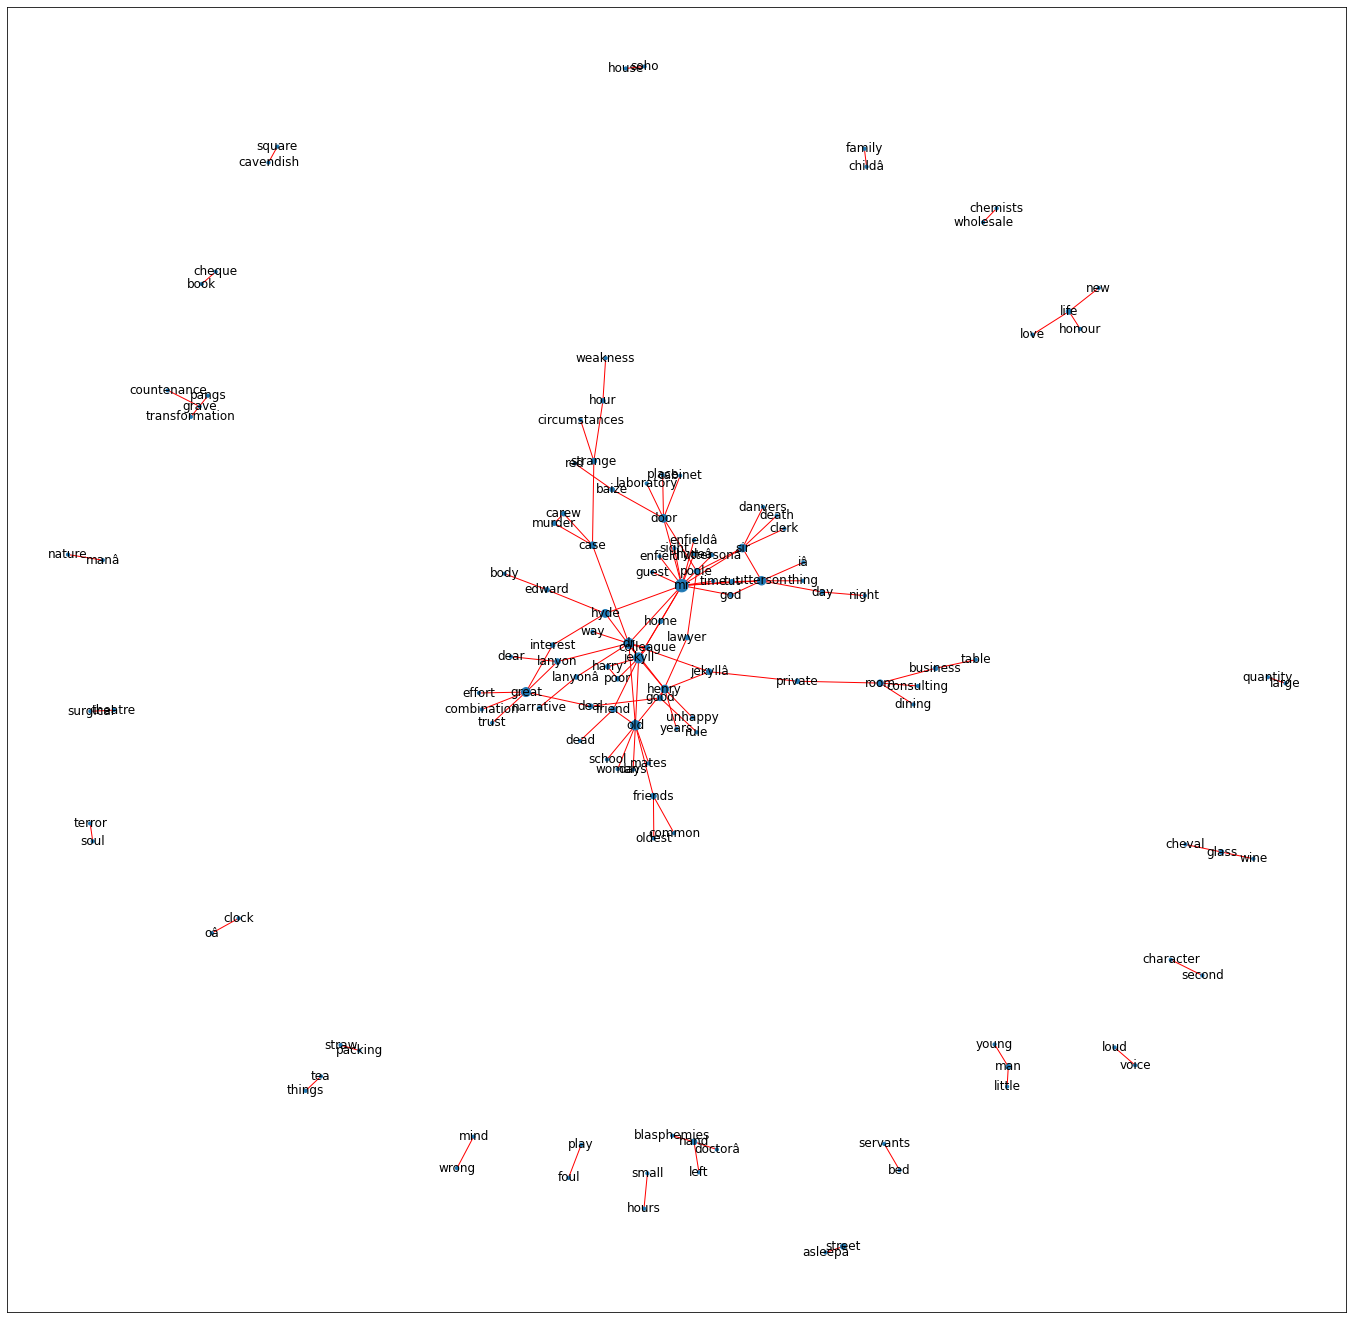

In [12]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(24,24)) 
nx.draw_networkx(G, with_labels = True, node_size=[v * 10 for v in dict(G.degree).values()], edge_color = 'r')

Alternatively, the network can be exported as a Gephi-compatible format (like .gexf).

In [13]:
nx.write_gexf(G, "jekyll-hyde_wordpairs_filter-5.gexf")